## Laboratorium 12

## Ocena podobieństwa elementów wizualnych za pomocą _triple nets_

#### Wstęp

W pewnej klasie zadań możemy nie dysponować konkretnymi etykietami dla danych, lecz zbiór jest ustrukturyzowany w taki sposób, że dysponujemy kilkoma przykładami dla każdej _instancji_. Do klasy tej należą zadania takie jak np. identyfikacja twarzy (dane jest wiele różnych osób, ale dla każdej z nich mamy niewielką liczbę obrazów uczących), czy wyszukiwania obszarów podobnych (dany jest element wizualny, należy znaleźć podobne mu obrazy) - szerzej: gdy liczba klas jest duża, a przykładów dla każdej z nich jest niewiele.

Podejście klasyfikacyjne do takich problemów nie zawsze się udaje - nauczenie klasyfikatora, gdy dla pewnej klasy mamy ledwie 2 czy 3 obrazy, stanowi duże wyzwanie. W tych sytuacjach często stosuje się podejście uczenia podobieństwa. Wykorzystuje się w tym celu różne warianty sieci syjamskich (_Siamese networks_) czy trójkowych (_triple nets_); na laboratorium przetestujemy podstawowe podejście bazujące na triple necie wg Schroff et al. - _FaceNet: A Unified Embedding for Face Recognition and Clustering_ (2015) [[1](https://arxiv.org/abs/1503.03832)].

Metody te łączy fakt, że uczymy nie klasyfikator, który w jakiś sposób "tnie" wysokowymiarową przestrzeń danych na podobszary-klasy, ale enkoder, osadzający (_embedding_) próbki w takiej przestrzeni, że przykłady podobne sobie wizualnie znajdują się w tej przestrzeni "blisko siebie" (wg jakiejś przyjętej miary odległości).

#### Triplet loss

Załóżmy, że mamy pewną sieć konwolucyjną (_backbone_), która tworzy wektorowe reprezentacje dla podanych obrazów. Chcemy nauczyć ją w taki sposób, by reprezentacje obrazów sobie podobnych leżały "blisko" w przestrzeni reprezentacji. Musimy zatem zaproponować taką funkcję kosztu, która będzie ten cel realizować. Podejście, którym zajmiemy się na zajęciach, oparte jest o funkcję kosztu zwaną _triplet loss_. Intuicja za nią jest następująca:
* wybieramy losowy obraz z datasetu, $A$ (od _anchor_),
* wybieramy losowy obraz z **tej samej klasy**, $P$ (_positive_),
* wybieramy losowy obraz z **innej** klasy, $N$ (_negative_),
* propagujemy gradienty w taki sposób, by minimalizować odległość (wg jakiejś przyjętej metryki $D$) między $A$ i $P$, a zarazem maksymalizować odległość między $A$ i $N$.

Matematycznie, funkcja triplet loss wyraża się w następujący sposób:
$$L_{triplet} = \max(\Vert f(x_A)^2 - f(x_P)^2\Vert_{2}^2 - \Vert f(x_A)^2 - f(x_N)^2\Vert_{2}^2 + \alpha; 0)$$
gdzie $f(x)$ jest funkcją enkodującą próbkę $x$ (a więc obraz) do przestrzeni reprezentacji (a więc naszą siecią backbone), a $\Vert v \Vert_{2}^2$ oznacza długość wektora $v$ według metryki Euklidesowej. Wspomnieć należy, że można przyjmować różne miary odległości. $\alpha$ stanowi zaś _margines_ - minimalną (dodatnią) wartość różnicy w odległości, dla której wartość funkcji wynosi zero. Zadaniem marginesu jest ograniczenie wpływu łatwych przypadków, które już leżą bardzo blisko siebie i łatwo byłoby je jeszcze bardziej przybliżać; dzięki wyzerowaniu funkcji kosztu dla takich przypadków, sieć uczy się tylko z par "trudnych". W praktyce wystarczy zaś, by podobne próbki leżały w odległości właśnie poniżej tego marginesu - jeśli tylko próbki różne będą wystarczająco rozdzielone.

#### Normalizacja

W podejściu _triple net_ embeddingi wytworzone przez sieć konwolucyjną poddaje się normalizacji $L2$ (przed obliczeniem dystansów i funkcji straty). Dzięki temu uzyskuje się proporcjonalność odległości $L2$ między embeddingami do ich podobieństwa cosinusowego (co można [łatwo udowodnić](https://en.wikipedia.org/wiki/Cosine_similarity#Properties)). Powoduje to, że embeddingi umieszczane są na powierzchni $d$-wymiarowej hipersfery (gdzie $d$ jest wymiarem przestrzeni osadzeń - jest to parametr metody, którego wartość musimy przyjąć).

Podany wyżej wzór na $L_{triplet}$ ze względu na swoją złożoność nie zawiera normalizacji, której należy poddać każdy z elementów $f(x_i)$.

### Uczenie

Naturalną różnicą pomiędzy podejściem triple net a np. klasyfikacją jest konieczność losowania trójek obrazów z datasetu. Może to nastręczać pewnych kłopotów przy implementacji - zwłaszcza, jeśli zainteresujemy się podejściami typu [_hard mining_](https://omoindrot.github.io/triplet-loss#triplet-mining): w skrócie, wyszukiwanie najtrudniejszych przypadków, dla których różnica w odległościach będzie największa (a więc bardzo odległych od siebie pozytywów i bardzo bliskich negatywów). Dla uproszczenia pominiemy kwestię metody doboru sampli, choć w praktyce ma ona duży wpływ na dynamikę uczenia i finalną jakość modelu.

Pełen pipeline wyglądać zatem będzie następująco:
* pobieramy trójkę $A$, $P$, $N$ z datasetu,
* wykorzystujemy dowolną wstępnie nauczoną sieć konwolucyjną do obliczenia embeddingów dla wylosowanych obrazów  
(uwaga: o ile część konwolucyjną możemy zamrozić na potrzeby uczenia, komponent _fully connected_ musi zostać nauczony od nowa!),
* normalizujemy embeddingi ($L2$),
* obliczamy wartość funkcji kosztu $L_{triplet}$.

Klasa `TripletDataset` owijająca zwykły dataset w taki sposób, by generować trójki zgodnie z metodą, jest dołączona do instrukcji. Podobnie, dana jest klasa `Normalize`. Funkcję kosztu [`TripletMarginWithDistanceLoss`](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss) znajdziesz w dokumentacji PyTorch.

W zadaniu korzystać będziemy z datasetu CIFAR100 ze względu na jego niewielki, ale wystarczający rozmiar, dużą liczbę klas (100), oraz dostępność w module [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.CIFAR100).

In [1]:
import os
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision as tv
import torchvision.models as M
import torchvision.transforms as T

In [2]:
class TripletDataset(torch.utils.data.Dataset):
    """Wrapper dataset that draws triplets from the source_dataset.

    size: arbitrary 'length' of dataset, number of triplets to draw in one epoch
    """
    def __init__(self, source_dataset, size:int):
        super(TripletDataset, self).__init__()
        self.class_bags = [[] for _ in source_dataset.classes]
        
        for image, label in source_dataset:
            self.class_bags[label].append(image)
            self.count = sum(len(bag) for bag in self.class_bags)
            self.size = size
            self.ncls = len(self.class_bags)

    def __len__(self):
        return self.size

    def __getitem__(self, i):
        return self.get_random_triplet()

    def get_random_triplet(self):
        anchor_class = random.randint(0, self.ncls-1)
        anchor = random.choice(self.class_bags[anchor_class])
        positive = random.choice(self.class_bags[anchor_class])
        negative_class = random.randint(0, self.ncls-2)
        if negative_class >= anchor_class:
            negative_class += 1
        negative = random.choice(self.class_bags[negative_class])
        return anchor, positive, negative

In [3]:
data_transform = T.Compose([
  T.ToTensor(),
  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# PATH = '/content'
PATH = './content'
cifar_train = tv.datasets.CIFAR100(root=PATH, train=True, download=True, transform=data_transform)

Files already downloaded and verified


In [5]:
train_triplet_dataset = TripletDataset(cifar_train, 10000)
train_triplet_loader = torch.utils.data.DataLoader(train_triplet_dataset, batch_size=64, num_workers=6)

---

### Zadanie 1 (2.0 pkt | 1.0 pkt)

Uzupełnij pętlę uczenia dla metody triple net wg algorytmu podanego we wstępie.

Wybierz pretrenowany backbone konwolucyjny, usuwając jego ostatni moduł ("klasyfikator") i dostawiając nowy moduł `Linear` o porównywalnej (64-512) liczbie wyjść (tj. wymiar przestrzeni embeddingu). Przeprowadź proces uczenia modelu z parametrami optymalizatora (_learning rate_, liczba epok) dobranymi "na oko" - tzn. to nie jest najważniejsza część laboratorium, uczenie nie ma zająć Ci dużo czasu.

In [6]:
class Normalize(torch.nn.Module):
    def __init__(self, p:float):
        super(Normalize, self).__init__()
        self.p = p
    
    def forward(self, x):
        return torch.nn.functional.normalize(x, p=self.p, dim=1)


def epoch(backbone, head, data_loader, optim, device):
    backbone.train()
    head.train()
    
    loss_fun = torch.nn.TripletMarginLoss()
    
    normalize = Normalize(2.0)
    avg_loss = 0.0
    n_batches = 0
    for anchors, positives, negatives in data_loader:
        with torch.no_grad():
            embed_a = backbone(anchors.to(device))
            embed_p = backbone(positives.to(device))
            embed_n = backbone(negatives.to(device))
            
        embed_a = head(embed_a)
        embed_p = head(embed_p)
        embed_n = head(embed_n)
        
        embed_a = normalize(embed_a)
        embed_p = normalize(embed_p)
        embed_n = normalize(embed_n)
        
        loss = loss_fun(embed_a, embed_p, embed_n)
        loss.backward()

        optim.step()
        optim.zero_grad()
        avg_loss += loss.item()
        n_batches += 1
        
    return avg_loss / n_batches

In [7]:
net = M.resnet18(pretrained=True)
# net

In [8]:
net.fc = torch.nn.Identity()
head = torch.nn.Linear(512, 256)

In [9]:
from tqdm.auto import tqdm, trange

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
head.to(device)
optimizer = torch.optim.Adam(head.parameters(), lr=0.001)

losses = []

p_bar = trange(50, desc="Training")
for i in p_bar:
    loss = epoch(net, head, train_triplet_loader, optimizer, device)
    
    p_bar.update(1)
    p_bar.set_description(f"Loss {loss}")
    losses.append(loss)
    # print(loss)
    
torch.save(head.state_dict(), 'head_256_50.pt')

Training:   0%|          | 0/50 [00:00<?, ?it/s]

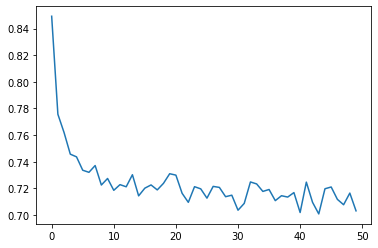

In [13]:
plt.plot(list(range(50)), losses);

### Komentarz 1

W zadaniu wykorzystano pretrenowany model _ResNet18_. Wymiar ostatniej warstwy został ustawiony na $256$. Eksperyment został przeprowadzony ze współczynnikiem uczenia $lr=0.001$, liczbą epok $epochs=50$, a jako funkcję straty posłużyła _TripletMarginLoss_.

Wykres funkcji straty prezentuje poprawny spadek wartości _loss_ w zależności od numeru epoki. Krzywa wypłaszcza się po 30. epoce. Późniejsze wachania wartości funkcji są spowodowane stosunkowo wysoką wartością współczynnika uczenia i braku mechanizmu zmniejszania go w zależności od kroku uczenia.

---

### Zadanie 2 (1.0 pkt | 1.0 pkt)

Przetestuj nauczony model w następujący sposób: wybierz z datasetu (testowego!) kilka dowolnych przykładów z różnych klas, a następnie przeszukaj resztę datasetu, dla każdego z nich wyciągając kilka (5-10) najbliższych (wg. przyjętego dystansu w przestrzeni osadzeń) obrazów.

Wyniki przedstaw graficznie, sprawdź też czy znalezione obrazy należą do tych samych klas.

Nie chodzi o wyczerpujące przejrzenie datasetu i liczenie metryk, tylko wizualną ocenę. _Jeśli bardzo chcesz_, możesz wykonać dodatkowy eksperyment z klasteryzacją embeddingów, ale nie jest to część zadania.

In [14]:
cifar_test = tv.datasets.CIFAR100(root=PATH, train=False, download=False, transform=data_transform)

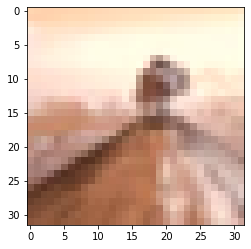

In [15]:
net.eval()

image, cid = cifar_test[0] # zwraca już krotkę (tensor CxHxW, int)
# aby propagować przez sieć neuronową:
out = net(image[None, ...].to(device))
# aby powrócić do formatu OpenCV (float32 BGR)
image = image.numpy()
image = np.clip(image[::-1, ...].transpose((1,2,0)) * np.asarray([0.229, 0.224, 0.225]) + np.asarray([0.485, 0.456, 0.406]), 0.0, 1.0)

plt.imshow(image);

In [20]:
normalize = Normalize(2.0)

head = torch.nn.Linear(512, 256)
head.load_state_dict(torch.load('head_256_50.pt', map_location='cpu'))

net.eval()
head.eval()

with torch.no_grad():
    embeddings = []
    labels = []
    for image, cid in tqdm(cifar_test):
        out = net(image[None, ...].to(device))
        out = head(out)
        out = normalize(out)
        labels.append(cid)
        embeddings.append(out)
        # if len(embeddings) >= 1000:
        #     break
            
embeddings = torch.concat(embeddings)

  0%|          | 0/10000 [00:00<?, ?it/s]

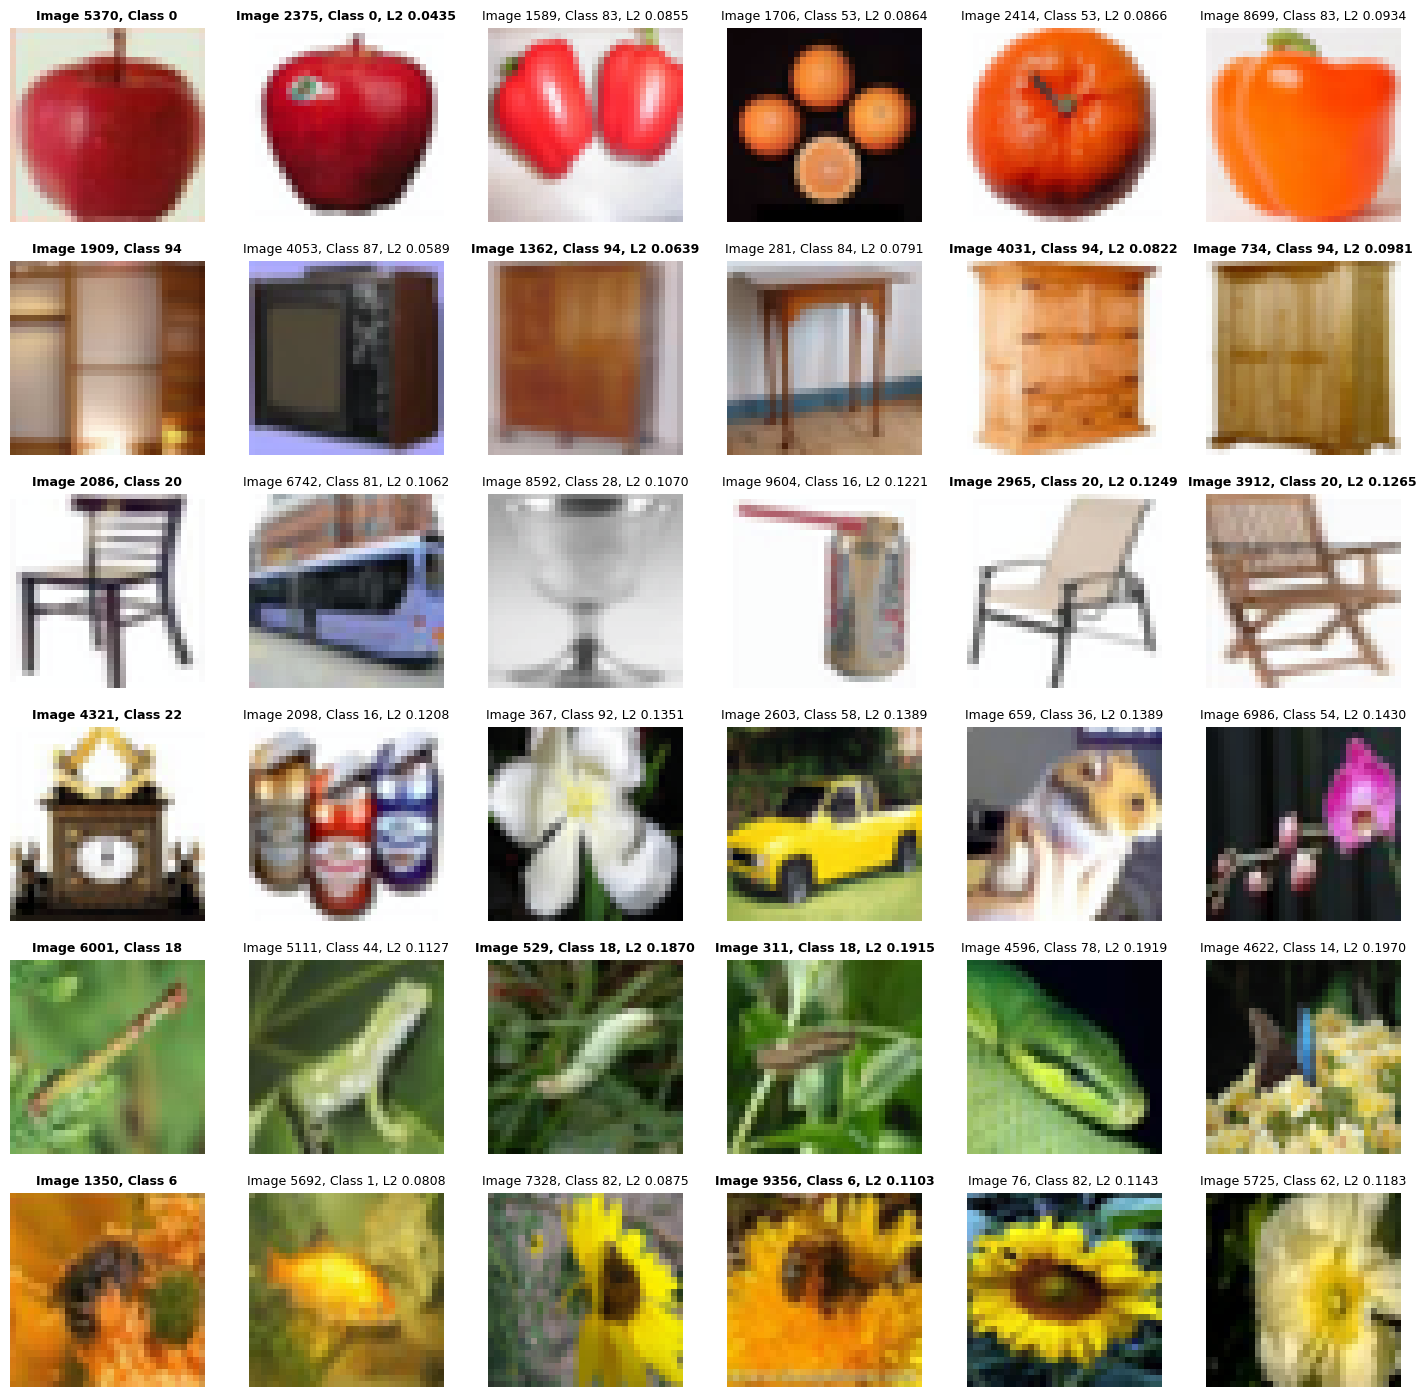

In [21]:
indices = [5370, 1909, 2086, 4321, 6001, 1350]
k = 5

distance = torch.nn.PairwiseDistance()


def get_image(image):
    image = image.numpy()
    return np.clip(image.transpose((1,2,0)) * np.asarray([0.229, 0.224, 0.225]) + np.asarray([0.485, 0.456, 0.406]), 0.0, 1.0)


fig, axes = plt.subplots(len(indices), k + 1, figsize=(3 * (k+1), 3 * len(indices)), dpi=100)

with torch.no_grad():
    for i, idx in enumerate(indices):
        image, cid = cifar_test[idx]

        distances = distance(embeddings[idx], embeddings)
        distances[idx] += 100
        top_indices = distances.argsort()[:k]
        
        axes[i, 0].imshow(get_image(image))
        axes[i, 0].set_title(label=f"Image {idx}, Class {cid}", fontsize=9, fontweight='bold')
        
        for top_i, top_idx in enumerate(top_indices, start=1):
            top_image, top_cid = cifar_test[top_idx]
            
            axes[i, top_i].imshow(get_image(top_image))
            axes[i, top_i].set_title(label=f"Image {top_idx}, Class {top_cid}, L2 {distances[top_idx]:.4f}", fontsize=9, fontweight='bold' if cid == top_cid else 'normal')
            
        
        for ax in axes[i]:
            ax.axis("off")

In [22]:
from sklearn.cluster import KMeans

x = embeddings.numpy()

kmeans = KMeans(n_clusters=100)
kmeans.fit(x)

KMeans(n_clusters=100)

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE()
x_embeded = tsne.fit_transform(x)

/home/mateusz-baran/miniconda3/envs/obrazy/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mateusz-baran/miniconda3/envs/obrazy/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


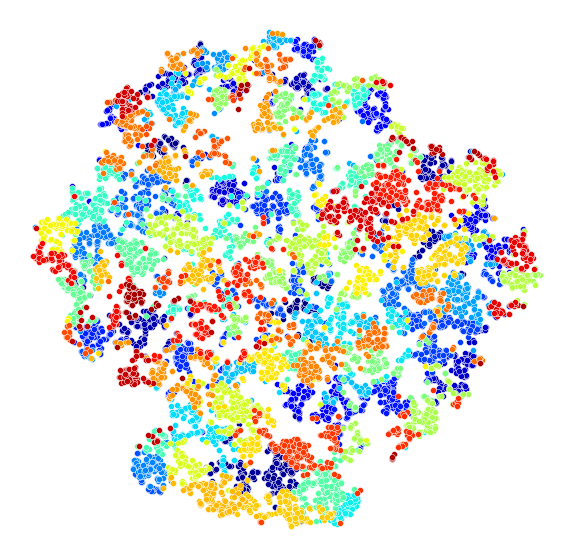

In [24]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))
ax.axis("off")

cmap = plt.cm.jet
for i, label in enumerate(set(kmeans.labels_)):
    mask = kmeans.labels_ == label
    sns.scatterplot(x=x_embeded[:, 0][mask], y=x_embeded[:, 1][mask], ax=ax, color=cmap(int(i * 2.5 % cmap.N)));

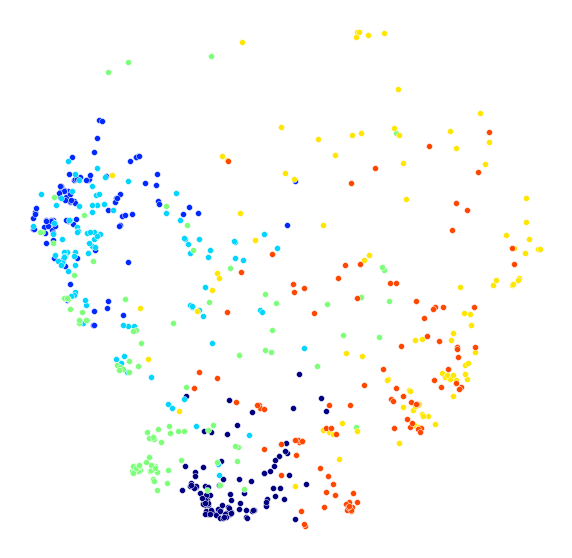

In [25]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))
ax.axis("off")

cmap = plt.cm.jet
for i, label in enumerate([cifar_test[idx][1] for idx in indices]):
    mask = [lbl == label for lbl in labels]
    sns.scatterplot(x=x_embeded[:, 0][mask], y=x_embeded[:, 1][mask], ax=ax, color=cmap(int(i * 256 / len(indices) % cmap.N)));

### Komentarz 2

Zdjęcia ze zbioru testowego zostały przepuszczone przez wcześniej wyuczony model. Ze zbioru wybrano 6 losowych zdjęć, których embeddingi porównano (dystans L2) z pozostałymi w celu wybrania $k=5$ najbardziej podobnych. 

W pierwszej kolumnie umieszczone są wybrane obrazy. Pogrubiony tytuł oznacza, że obrazy należą do tej samej klasy.

Jakość modelu nie należy do najlepszych. Znajduje on obrazy podobne do siebie, lecz nie należą do tej samej klasy np. jabłko i pomidor. Istnieją klasy obrazów dla których model całkowicie nie radzi i zwraca całkowicie różne od siebie zdjęcia. Wizualizację pokazują jak została sklasteryzowana przestrzeń zaembedowanych obrazów ze zbioru testowego oraz druga pokazuje jak zostały rozłożone klasy wybranych obrazów do analizy. Widzimy dobre zgrupowanie kilku obrazów w każdej z klas, ale duża część jest rozproszona po całej przestrzeni. 

Aby poprawić wyniki należy przeuczyć model przez większą liczbę epok, ustawić odpowiednie hiperparametry oraz uczyć również wartstwy backbone. Można dodatkowo zastsować Funkcję straty wyostrzającą granicę między obrazem positive i negative w stosunku do obrazu anchor.